### An example showing how to estimate (Mr, FeH, Ar) using a catalog of stellar photometry
### and Bayesian method (with TRILEGAL priors)

In [1]:
%matplotlib inline
import sys
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import hstack
import matplotlib.pyplot as plt 
import numpy as np
from scipy import stats
from scipy import optimize
from scipy.stats import gaussian_kde
# from scipy import interpolate 
from scipy.interpolate import griddata

In [2]:
## automatically reload any modules read below that might have changed (e.g. plots)
%reload_ext autoreload
%autoreload 2
# importing plotting and locus tools: 
sys.path.append('../src')
import LocusTools as lt
import BayesTools as bt
import PlotTools as pt

### read a catalog of stellar photometry

In [79]:
## read TRILEGAL sim-based data file, augmented with LSST colors 
## the input data are limited to 0.2 < g-i < 3.0 and
## -2.5 < FeH < 0 and Mr > -1.0 and log(g) < 7 and rmag < 26 
#sims = lt.readTRILEGALLSST(inTLfile='../data/simCatalog_three_pix_triout_v1.txt')
sims = lt.readTRILEGALLSST(inTLfile='../data/simCatalog_three_pix_triout_chiTest4.txt', chiTest=True)
sims[0:2]

READING FROM ../data/simCatalog_three_pix_triout_chiTest4.txt
814450 read from ../data/simCatalog_three_pix_triout_chiTest4.txt


glon,glat,comp,logg,FeH,Mr,DM,Ar,rmag0,ug0,gr0,ri0,iz0,rmag,ug,gr,ri,iz,uErr,gErr,rErr,iErr,zErr,ugSL,grSL,riSL,izSL,ugErrSL,grErrSL,riErrSL,izErrSL,gi0,gi,gmag,umag,imag,zmag,ugErr,grErr,riErr,izErr
float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.94839984,-45.11469269,1,4.95,-0.51,11.44,8.9,0.096,20.43,2.458,1.396,1.355,0.705,20.43,2.497,1.435,1.378,0.724,0.06,0.006,0.005,0.005,0.005,2.549,1.434,1.378,0.729,0.063,0.008,0.007,0.007,2.751,2.8129999999999997,21.865,24.362,19.052,18.328,0.060299253726725344,0.0078102496759066544,0.007071067811865475,0.007071067811865475
0.21957318,-44.95205688,1,5.07,-0.49,13.04,8.65,0.12,21.81,2.58,1.478,1.723,0.943,21.82,2.629,1.526,1.752,0.967,0.249,0.011,0.006,0.005,0.005,2.369,1.547,1.756,0.956,0.2,0.013,0.008,0.007,3.201,3.278,23.346,25.975,20.068,19.101000000000003,0.24924285345822858,0.012529964086141668,0.0078102496759066544,0.007071067811865475


### read stellar locus parametrization

In [80]:
LSSTlocus = lt.LSSTsimsLocus(fixForStripe82=False)
LSSTlocus[0:2]

Mr,FeH,ug,gr,ri,iz,zy,gi
float64,float64,float64,float64,float64,float64,float64,float64
-1.0,-2.5,1.3805,0.578,0.265,0.1681,0.0803,0.843
-0.99,-2.5,1.3793,0.5776,0.2648,0.1679,0.0802,0.8424


In [81]:
## TEMPORARY HACK, until Ar fitting implemented...
# because assuming below that Ar is known, fitting ug0, gr0 (these are unreddened colors)...  
# eventually we'll work with ug, gr... but for now we want to fit ug0, gr0... from sims

# we also need errors for ug0, gr0... 
sims['ug0Err'] = sims['ugErr'] 
sims['gr0Err'] = sims['grErr'] 
sims['ri0Err'] = sims['riErr'] 
sims['iz0Err'] = sims['izErr'] 

# an awkward solution for now (because not considering fitting Ar yet): 
LSSTlocus['ug0'] = LSSTlocus['ug']
LSSTlocus['gr0'] = LSSTlocus['gr']
LSSTlocus['ri0'] = LSSTlocus['ri']
LSSTlocus['iz0'] = LSSTlocus['iz']

# setup arrays for holding results
sims['MrEst'] = 0*sims['Mr'] - 99 
sims['MrEstUnc'] = 0*sims['Mr'] -1 
sims['FeHEst'] = 0*sims['Mr'] - 99
sims['FeHEstUnc'] = 0*sims['Mr'] - 1 
sims['chi2min'] = 0*sims['Mr'] + 999
sims['MrdS'] = 0*sims['Mr'] + 999
sims['FeHdS'] = 0*sims['Mr'] + 999

# for chi testing: reddening-corrected true (w/o noise) colors
colors = ('ug', 'gr', 'ri', 'iz')  
for c in colors:
    sims[c+'SL0'] = sims[c+'SL'] + sims[c+'0'] - sims[c]

### we estimate distance for all sources first, and only later we test with proper magnitude and color cuts 

In [82]:
# we will select the color range where we expect main sequence and red giants
OKlocus = LSSTlocus[(LSSTlocus['gi']>0.2)&(LSSTlocus['gi']<3.5)]

In [83]:
## using observations in sims, and isochrones in OKlocus, 
## and given ug, gr, ri, iz (and errors): estimate MrEst and FeHEst 
##        (for now ignoring ArEst, so working with ug0 etc instead of ug...) 
## and store in file for later perusal...

 showing detailed results for star i= 0
Mr: 11.12718190679586  +-  0.18447169880221365
FeH: -0.2391068182417884  +-  0.1882404720028776
Mr drop in entropy: -300.2839921735495
FeH drop in entropy: -24.14472112116439


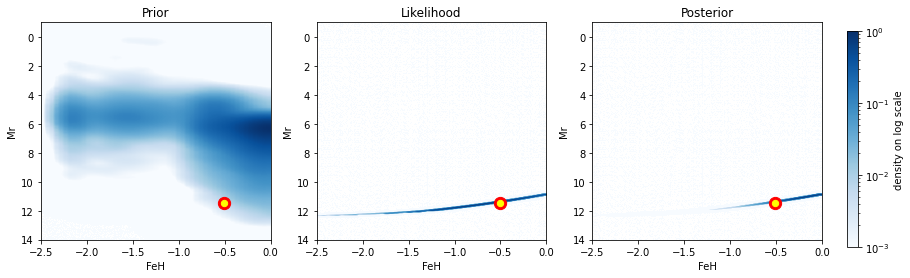

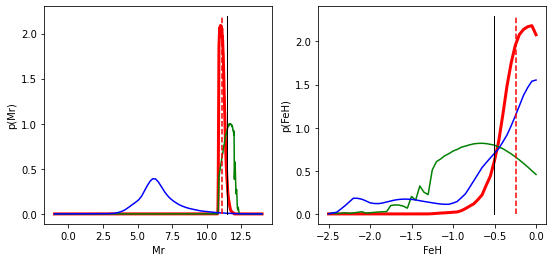

 showing detailed results for star i= 100000
Mr: 3.85612321658614  +-  0.13439963306773373
FeH: -0.14551771535354574  +-  0.04901868698385746
Mr drop in entropy: -307.98354438543157
FeH drop in entropy: -42.26391961709558


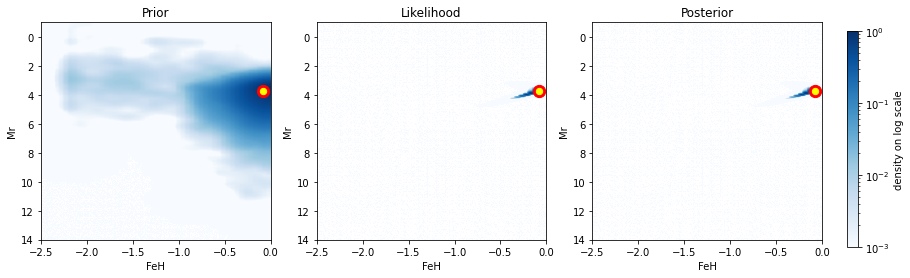

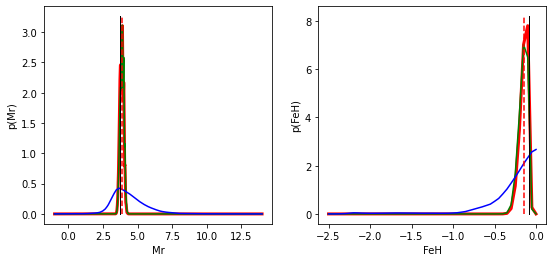

 showing detailed results for star i= 200000
Mr: 4.4281897371905785  +-  0.10515874109896309
FeH: -0.5888856551361706  +-  0.06844899338018198
Mr drop in entropy: -363.8591173749581
FeH drop in entropy: -46.3019139413654


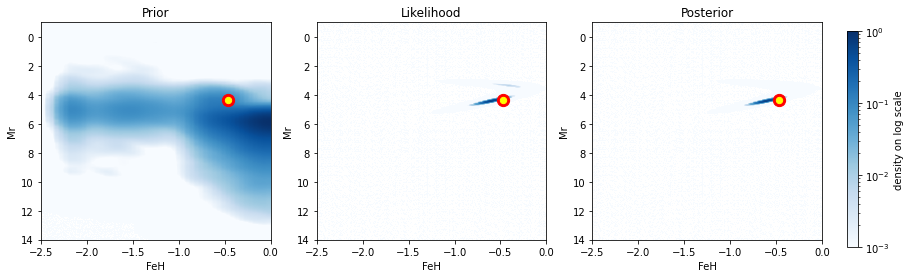

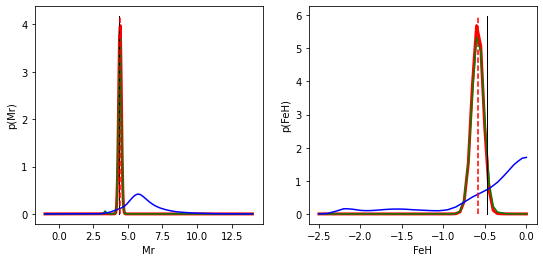

 showing detailed results for star i= 300000
Mr: 10.311958211242823  +-  0.3926352374791653
FeH: -1.3222180125591902  +-  0.581625082337891
Mr drop in entropy: -172.67590946754825
FeH drop in entropy: 0.8832194248075993


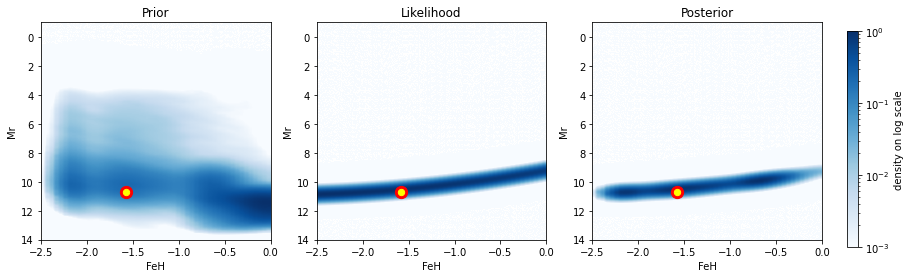

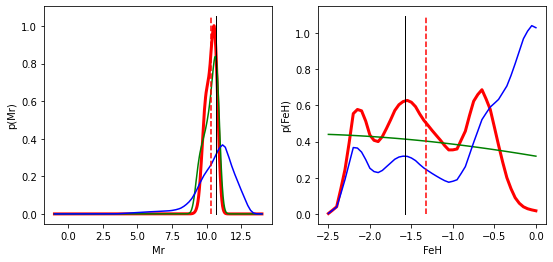

 showing detailed results for star i= 400000
Mr: 10.668881262933525  +-  0.25492519656036505
FeH: -0.3033405213042919  +-  0.27233303325240876
Mr drop in entropy: -247.78523739538988
FeH drop in entropy: -24.574208673008137


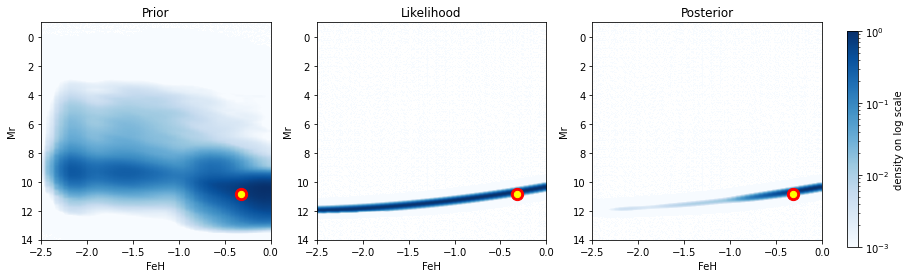

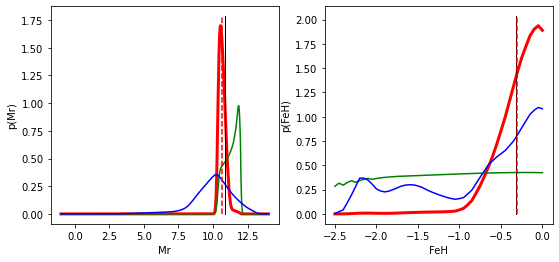

 showing detailed results for star i= 500000
Mr: 11.135524020472547  +-  0.2983790546390494
FeH: -0.37285648703102725  +-  0.31440565086994887
Mr drop in entropy: -210.58759668883548
FeH drop in entropy: -20.505108714142526


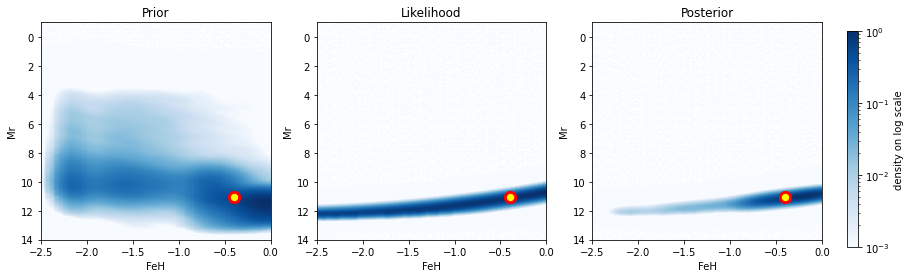

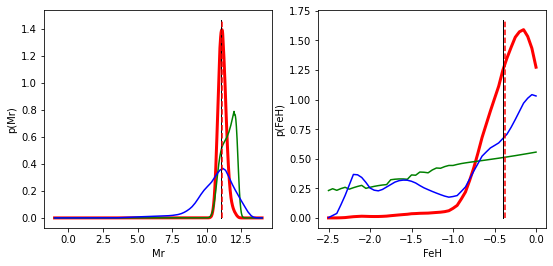

In [84]:
### 
catalog = sims
fitColors = ('ug0', 'gr0', 'ri0', 'iz0')  # use extinction-corrected colors, no z-y yet 
locusData = OKlocus
priorsRootName = '../data/TRILEGALpriors/priors'
# outfile = '../data/simCatalog_three_pix_triout_v1_BayesEstimates.txt'
outfile = '../data/simCatalog_three_pix_triout_chiTest4_BayesEstimates.txt'
iStart = 0
iEnd = -1  # signal to do all stars
#myStars = [0, 100000, 200000, 300000, 400000, 500000, 600000, 700000]  # make plots for these stars
myStars = [0, 100000, 200000, 300000, 400000, 500000]  # make plots for these stars
verb=False 
bt.makeBayesEstimates(catalog, fitColors, locusData, priorsRootName, outfile, iStart, iEnd, myStars, verbose=verb)

## this is it...
## or, instead of calling makeBayesEstimates(), step by step...

In [57]:
# read maps with priors (and interpolate on the locus Mr-FeH grid which is same for all stars)
priorGrid = bt.readPriors(rootname='../data/TRILEGALpriors/priors', locusData=OKlocus) 

In [58]:
# get prior map indices using observed r band mags
priorind = bt.getPriorMapIndex(sims['rmag'])

In [59]:
# Mr and FeH 1-D grid properties extracted from locus data (same for all stars)
xLabel = 'FeH'
yLabel = 'Mr'
FeHGrid = OKlocus[xLabel]
MrGrid = OKlocus[yLabel]
FeH1d = np.sort(np.unique(FeHGrid))
Mr1d = np.sort(np.unique(MrGrid))  
# grid step
dFeH = FeH1d[1]-FeH1d[0]
dMr = Mr1d[1]-Mr1d[0]

# Mr and DeH axis limits and # of points used with likelihood maps
mdLocus = bt.getMetadataLikelihood(OKlocus)

In [60]:
!date

Wed Sep  6 15:52:47 PDT 2023


 showing detailed results for star i= 0
Mr: 10.439756259007904  +-  0.22557713581392247
FeH: -0.3528449876366084  +-  0.2503844447000786
Mr drop in entropy: -270.0278895141883
FeH drop in entropy: -16.303024476842392


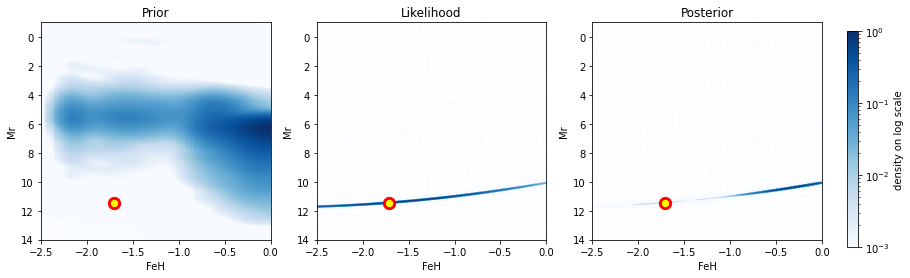

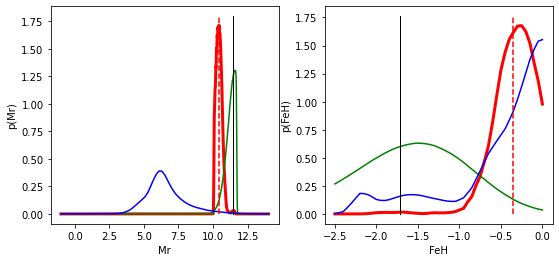

In [61]:
colors0 = ('ug0', 'gr0', 'ri0', 'iz0')  # ignoring z-y and Ar for now (fitPhotoD cannot do it, only Mr and FeH)
#colors0 = ('ug0', 'gr0')  # ignoring z-y and Ar for now (fitPhotoD cannot do it, only Mr and FeH)
# do all, or a range of stars
doAllStars = False
if (doAllStars):
    iStar1 = 0
    iStar2 = np.size(sims)
else:
    iStar1 = 0
    iStar2 = 1
# show plots for chosen stars
myStars = [0, 100000, 200000, 300000, 400000]
# and now analyze star by star    
verbose = False
for i in range(iStar1, iStar2):
    if (verbose):
        print(' ----------- ')
        print('    i =', i, 'working on star', i)
    # chi2 map for this star, for provided isochrones
    chi2map = lt.getPhotoDchi2map(i, colors0, sims, OKlocus)
    sims['chi2min'][i] = np.min(chi2map)
    
    # likelihood map 
    likeGrid = np.exp(-0.5*chi2map)
    # interpolated prior map onto the same Mr-FeH grid as likelihood map
    prior = priorGrid[priorind[i]] 
    # posterior pdf 
    posterior = likeGrid * prior 
    # reshape
    prior2d = prior.reshape(np.size(FeH1d), np.size(Mr1d))
    like2d = likeGrid.reshape(np.size(FeH1d), np.size(Mr1d))
    post2d = posterior.reshape(np.size(FeH1d), np.size(Mr1d))

    ## process to get expectation values and uncertainties
    # marginalize and get stats 
    margpostMr = {}
    margpostFeH = {}
    margpostMr[0], margpostFeH[0] = bt.getMargDistr(prior2d, dMr, dFeH)
    margpostMr[1], margpostFeH[1] = bt.getMargDistr(like2d, dMr, dFeH) 
    margpostMr[2], margpostFeH[2] = bt.getMargDistr(post2d, dMr, dFeH) 

    # stats
    sims['MrEst'][i], sims['MrEstUnc'][i] = bt.getStats(Mr1d, margpostMr[2])
    sims['FeHEst'][i], sims['FeHEstUnc'][i] = bt.getStats(FeH1d, margpostFeH[2])
    sims['MrdS'][i] = bt.Entropy(margpostMr[2])-bt.Entropy(margpostMr[0])
    sims['FeHdS'][i] = bt.Entropy(margpostFeH[2])-bt.Entropy(margpostFeH[0])
    
    if (i in myStars):
        # plot 
        print(' showing detailed results for star i=', i)
        print('Mr:', sims['MrEst'][i], ' +- ', sims['MrEstUnc'][i])
        print('FeH:', sims['FeHEst'][i], ' +- ', sims['FeHEstUnc'][i])
        print('Mr drop in entropy:', bt.Entropy(margpostMr[2])-bt.Entropy(margpostMr[0]))
        print('FeH drop in entropy:', bt.Entropy(margpostFeH[2])-bt.Entropy(margpostFeH[0]))
        FeHStar = sims['FeH'][i]
        MrStar = sims['Mr'][i]
        pt.show3Flat2Dmaps(prior, likeGrid, posterior, mdLocus, xLabel, yLabel, logScale=True, x0=FeHStar, y0=MrStar)
        bt.showMargPosteriors(Mr1d, margpostMr, 'Mr', 'p(Mr)', FeH1d, margpostFeH, 'FeH', 'p(FeH)', MrStar, FeHStar)

In [62]:
np.min(chi2map)

0.03471302458115495

In [63]:
chi2map.size

76602

In [64]:
np.argmin(chi2map)

32772

2.5100166389872314 2.9877197810659006
1.4350384150579671 1.356677876124459
1.262765135887669 1.2459097442938196
0.6323659607431722 0.5800312528747225

 2.99  1.36  1.25  0.58

In [65]:
colors = ('ug', 'gr', 'ri', 'iz')  
for c in colors:
    print(c, sims[0][c+'SL'], sims[0][c+'ErrSL'], sims[0][c+'SL0'], sims[0][c+'0'], sims[0][c+'Err']) 
    chi = sims[0][c+'SL0']-sims[0][c+'0']

ug 2.464 0.059 2.4249999999999994 2.441 0.060299253726725344
gr 1.428 0.008 1.39 1.391 0.0078102496759066544
ri 1.179 0.007 1.156 1.16 0.007071067811865475
iz 0.627 0.007 0.608 0.609 0.007071067811865475


In [307]:
colors = ('ug', 'gr', 'ri', 'iz')  
chi2 = 0 
for c in colors:
    chi = (sims[0][c+'0'] - OKlocus[np.argmin(chi2map)][c+'0'])/sims[0][c+'Err']
    print(sims[0][c+'0'], OKlocus[np.argmin(chi2map)][c+'0'], sims[0][c+'Err'], 'chi:', chi)
    chi2 += chi**2
print('chi2=', chi2)

2.561 2.535 0.0608276253029822 chi: 0.42743736699392565
1.384 1.396 0.01414213562373095 chi: -0.8485281374238578
1.357 1.3579 0.01414213562373095 chi: -0.06363961030679798
0.715 0.7082 0.01414213562373095 chi: 0.48083261120684645
chi2= 1.1379527027026968


In [285]:
colors = ('ug', 'gr', 'ri', 'iz')  
chi2 = 0 
for c in colors:
    chi = (sims[0][c+'TL0'] - OKlocus[np.argmin(chi2map)][c+'0'])/sims[0][c+'Err']
    print(sims[0][c+'TL0'], OKlocus[np.argmin(chi2map)][c+'0'], chi)
    chi2 += chi**2
print('chi2=', chi2)

2.951 2.535 6.838997871902862
1.3219999999999998 1.396 -5.2325901807804565
1.2270000000000003 1.3579 -9.256027765731892
0.5609999999999999 0.7082 -10.408611819065987
chi2= 268.1651418918918


In [266]:
sims[0]

glon,glat,comp,logg,FeH,Mr,DM,Ar,rmag0,ug0,gr0,ri0,iz0,rmag,ug,gr,ri,iz,uErr,gErr,rErr,iErr,zErr,gi0,gi,gmag,umag,imag,zmag,ugErr,grErr,riErr,izErr,ug0Err,gr0Err,ri0Err,iz0Err,MrEst,MrEstUnc,FeHEst,FeHEstUnc,chi2min,MrdS,FeHdS
float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.94839984,-45.11469269,1,4.95,-0.51,11.44,8.9,0.1,20.35,2.51,1.435,1.263,0.632,20.43,2.549,1.473,1.286,0.651,0.1,0.1,0.1,0.1,0.1,2.698,2.7590000000000003,21.903,24.451999999999998,19.144,18.493,0.14142135623730953,0.14142135623730953,0.14142135623730953,0.14142135623730953,0.14142135623730953,0.14142135623730953,0.14142135623730953,0.14142135623730953,10.489825365086682,0.5148509894000661,-0.2199812540815769,0.19591322600312297,0.11667100000000022,-138.67170363805423,-25.27637161311015


In [203]:
!date

Mon Sep  4 16:33:40 PDT 2023


In [204]:
# 555548 stars done in 19 mins: 2 milisec per star (w/o Ar!)
# Karlo's NN: 14 stars per milisec = 28 times faster (and with Ar!)
# when rerunning with TRILEGAL_three_pix_triout_RealErrorsAdd2umag.txt it finished in 11 mins !?! 

In [208]:
sims['dMr'] = sims['Mr'] - sims['MrEst']
sims['dMrNorm'] = sims['dMr'] / sims['MrEstUnc'] 
sims['dFeH'] = sims['FeH'] - sims['FeHEst']
sims['dFeHNorm'] = sims['dFeH'] / sims['FeHEstUnc'] 
print('median uncertainty:', np.median(sims['MrEstUnc']), np.median(sims['FeHEstUnc']))
print('median error:', np.median(sims['dMr']), np.median(sims['dFeH']))
print('std for chi:', np.std(sims['dMrNorm']), np.std(sims['dFeHNorm']))

median uncertainty: 0.29193793438306065 0.3322416296739893
median error: 0.0005220201407301062 0.032043823458355575
std for chi: 0.8882139331144898 0.9235106627770021


In [206]:
outfile = '../data/TRILEGAL_three_pix_triout_RealErrors2_BayesEstimates.txt'
fout = open(outfile, "w")
fout.write("      glon       glat        FeHEst FeHUnc  MrEst  MrUnc  chi2min    MrdS     FeHdS \n")
for i in range(0,np.size(sims)):
    r1 = sims['glon'][i]
    r2 = sims['glat'][i]
    r3 = sims['FeHEst'][i]
    r4 = sims['FeHEstUnc'][i]
    r5 = sims['MrEst'][i]
    r6 = sims['MrEstUnc'][i]
    r7 = sims['chi2min'][i]
    r8 = sims['MrdS'][i]
    r9 = sims['FeHdS'][i]
    s = str("%12.8f " % r1) + str("%12.8f  " % r2) + str("%6.2f  " % r3) + str("%5.2f  " % r4)
    s = s + str("%6.2f  " % r5) + str("%5.2f  " % r6) + str("%5.2f  " % r7) 
    s = s + str("%8.1f  " % r8) + str("%8.1f  " % r9) + "\n"
    fout.write(s)             
fout.close() 